In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import sys
import torch as pt
import math

sys.path.insert(0, '..')

from nonlinear_function_space import Linear
from nonlinear_problems import LQGC
from nonlinear_solver import Solver,mynonlinear_Solver,mySolver_problemdependent

%load_ext autoreload
%autoreload 2

device = pt.device('cuda')

seed = 42

lqgc = LQGC(d=2, off_diag=0.1, T=50, seed=seed, delta_t=1)#no need anymore
IS_K = 20000#no need any more

d = 5
print_every = 1
lr = 0.001 # 0.1 with Adam # 10.0 with SGD 
K = 2000
L = 50
delta_t = 0.01
T = 0.2
OBsigma2 = 1
K_BPF_large, K_BPF_small = 100000, 200
replicate_num = 20

resample_kappa = 1

alpha = 0.1
N = int(T / delta_t)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# get observation value

In [4]:
def b(x):
    return (x/2 + 25 * x / (1 + pt.sum(x**2,dim=1, keepdim = True)) - x) / delta_t

#get y_observed
#consider the OU process: dX = -X + dW y_t \sim N(\cdot,X_t)
#observemethod = 'naive'
observemethod = 'observe'
y_observed = []
X_forOB = pt.ones(d).to(device).repeat(1, 1).to(device)#initial fixed
print(X_forOB.shape)
N_forOB = int(T / delta_t)
for n in range(N_forOB+1):
    print(X_forOB, end = ' ,')
    if(observemethod == 'observe'):
      y_observed.append(X_forOB**2/20 + pt.randn_like(X_forOB).to(device))#observe y
    if(observemethod == 'naive'):
      y_observed.append(pt.ones_like(X_forOB).to(device))
    X_forOB = X_forOB + delta_t * b(X_forOB) + math.sqrt(delta_t) * pt.randn_like(X_forOB).to(device)#move forward
print(1)
print('observed value:', y_observed)

torch.Size([1, 5])
tensor([[1., 1., 1., 1., 1.]], device='cuda:0') ,tensor([[4.6806, 4.6558, 4.5949, 4.7423, 4.7038]], device='cuda:0') ,tensor([[3.3313, 3.1962, 3.2505, 3.2796, 3.3747]], device='cuda:0') ,tensor([[3.3256, 3.0179, 3.1795, 3.2889, 3.0532]], device='cuda:0') ,tensor([[3.3581, 3.1161, 3.1176, 3.1117, 3.0393]], device='cuda:0') ,tensor([[3.4360, 3.2613, 3.0875, 3.2016, 3.0825]], device='cuda:0') ,tensor([[3.4048, 3.2731, 3.1200, 3.0072, 2.8433]], device='cuda:0') ,tensor([[3.4273, 3.5021, 3.1249, 3.1130, 3.1114]], device='cuda:0') ,tensor([[3.3603, 3.4178, 2.7683, 2.9862, 2.7816]], device='cuda:0') ,tensor([[3.4611, 3.5099, 2.7927, 3.0023, 2.8401]], device='cuda:0') ,tensor([[3.5807, 3.4635, 2.7616, 3.0400, 2.8511]], device='cuda:0') ,tensor([[3.6177, 3.4503, 2.8627, 2.9790, 2.8650]], device='cuda:0') ,tensor([[3.4754, 3.4236, 2.8613, 2.8980, 2.7543]], device='cuda:0') ,tensor([[3.5555, 3.3504, 2.8235, 2.8962, 2.7997]], device='cuda:0') ,tensor([[3.6467, 3.3916, 2.7008, 3.

# FA-APF

In [5]:
def gk(x,y):
    return np.exp(log_gk(x,y))

def log_gk(xx,yy):
    exponent = -0.5 * np.sum((xx**2/ 20 - yy ) ** 2, axis = 1)
    return exponent

def b_np(x):
    return (x/2 + 25 * x / (1 + np.sum(x**2,axis=1,keepdims=True)) - x) / delta_t

def b_np111(x):
    return (x/2 + 25 * x / (1 + np.sum(x**2)) - x) / delta_t

def gk_bdd1(xx,yy):
    exponent = -0.5 * np.sum((xx**2/ 20 - yy ) ** 2)
    return np.exp(exponent)


def vectorized_gaussian_multiplication(mu1, sigma1, mu2, sigma2):
    '''
    Vectorized computation for mean, cov, and integral of N(\cdot;mu1,sigma1) * N(\cdot;mu2,sigma2)
    '''
    d = mu1.shape[1]

    inv_sigma1 = np.linalg.inv(sigma1)
    inv_sigma2 = np.linalg.inv(sigma2)
    cov = np.linalg.inv(inv_sigma1 + inv_sigma2)
    cov_inv = inv_sigma1 + inv_sigma2
    mean = np.einsum('...ij,...j->...i', cov, np.einsum('...ij,...j->...i', inv_sigma1, mu1) + np.einsum('...ij,...j->...i', inv_sigma2, mu2))

    integral = np.power(2 * np.pi, d/2) * np.sqrt(np.abs(np.linalg.det(cov)))\
          * np.exp(0.5 * np.einsum('...i,...i->...', mean, np.einsum('...ij,...j->...i', cov_inv, mean))\
                    - 0.5 * np.einsum('...i,...i->...', mu1, np.einsum('...ij,...j->...i', inv_sigma1, mu1))\
                          - 0.5 * np.einsum('...i,...i->...', mu2, np.einsum('...ij,...j->...i', inv_sigma2, mu2)))

    return mean, cov, integral



'''
to modify
'''
def twistedchain_FAAPF(yk, barx, dt, sigma2):
    '''
    calculate exp(-|Hx-yk|^2/2sigma2)*exp(-|x-barx|^2/2dt) = integral * N(\cdot; mu,Sigma)
    return integral \cdot, my, sigma
    here Hii = 1 for 1 \leq i \leq d-2, other with Hij = 0
    '''
    d = barx.shape[1]

    mu = np.copy(barx)
    mu[:,:d-2] = (dt * yk[:,:d-2] + sigma2 * barx[:,:d-2]) / (dt + sigma2)

    diag_cov = np.ones_like(barx) * dt
    diag_cov[:,:d-2] = (sigma2 * dt) / (sigma2 + dt)

    inte = 1
    yk_last_two = yk[:, -2:]
    barx_last_two = barx[:, -2:]
    barx_trimmed = barx[:, :d-2]
    yk_trimmed = yk[:, :d-2]

    inte *= np.exp(-np.sum(yk_last_two**2, axis=1) / (2 * sigma2))
    inte *= np.power(2 * np.pi * dt, +2/2)
    inte *= np.power(2 * np.pi * (1 / ( (1/dt) + (1/sigma2))), +(d-2)/2)\
          * np.exp(-np.sum((barx_trimmed - yk_trimmed)**2, axis = 1) / (2 * (dt + sigma2)))




    return mu, diag_cov, inte





obs = np.array([y_observed[i].squeeze().to('cpu').numpy() for i in range(N + 1)])


K_FAAPF = 200
print('use', K_FAAPF, 'particles')

FAAPF_Z_forcompare, FAAPF_logZ_forcompare = [], []
y_observed_KBPFL = np.array([y_observed[n].repeat(K_FAAPF, 1).to('cpu').numpy() for n in range(N + 1)])

average_ESSnum_FAAPF = 0
ESS_ave = 0

for ii in range(replicate_num):

    ithESS_num = 0

    XX_FAAPF_np = np.ones((N + 1, K_FAAPF, d))  # initial particles
    
    g_prod = 1
    for n in range(N + 1):
        g_k = gk(XX_FAAPF_np[n], y_observed_KBPFL[n])
        
        if n == N:
            gphi_k = np.ones(K_FAAPF)

        else:
            #monte carlo for tildephi_k
            tildephi_k = 0
            Ntilde = 200
            for Nt in range(Ntilde):
                Xnewtest = XX_FAAPF_np[n] + delta_t* b_np(XX_FAAPF_np[n])\
                     + np.sqrt(delta_t) * np.random.randn(*XX_FAAPF_np[n].shape)
                tildephi_k += gk(Xnewtest,y_observed_KBPFL[n+1])

            tildephi_k /= Ntilde

            gphi_k = tildephi_k 


            if n == 0:
                gphi_k *= g_k

        g_prod *= gphi_k.mean()

        #resample
        
        weights = gphi_k / gphi_k.sum()
        indices = np.random.choice(K_FAAPF, K_FAAPF, p=weights, replace=True)
        ESS = 1.0 / np.sum(weights**2)
        ESS_ave += ESS

        if(ESS <= resample_kappa * K_FAAPF):
            XX_FAAPF_np_rs = XX_FAAPF_np[n][indices]
            ithESS_num += 1
        else:
            XX_FAAPF_np_rs = XX_FAAPF_np[n]
        
        if n <= N - 1:
            #reject sampling to move forward
            rejectnum = 0
            for ki in range(K_FAAPF):
                ifreject = 1
                while(ifreject == 1):
                    Xnewtest_i = XX_FAAPF_np_rs[ki] + delta_t * b_np111(XX_FAAPF_np_rs[ki])\
                          + np.sqrt(delta_t) * np.random.randn(*XX_FAAPF_np_rs[ki].shape)
                    acceptrate = gk_bdd1(Xnewtest_i, obs[n+1])
                    rd_accept = np.random.rand()
                    if(acceptrate > rd_accept):#accept
                        XX_FAAPF_np[n+1][ki] = Xnewtest_i
                        ifreject = 0
                    else:
                        rejectnum += 1
            
            if(n == 2):
                print("n=", n, "average reject:", rejectnum / K_FAAPF,end=' ')



    print(ii, 'logZ = ', np.log(g_prod))
    FAAPF_Z_forcompare.append(g_prod)
    FAAPF_logZ_forcompare.append(np.log(g_prod))
    average_ESSnum_FAAPF += ithESS_num

average_ESSnum_FAAPF /= replicate_num
if(resample_kappa < 1):
    print('average ESS number:', average_ESSnum_FAAPF)


ESS_ave /= (replicate_num * (N+1))
print('average_ESS=', ESS_ave, 'average_ESS percentage = ', ESS_ave / K_FAAPF)

use 200 particles
n= 2 average reject: 4.62 0 logZ =  -52.88100791276892
n= 2 average reject: 4.8 1 logZ =  -52.52815065200618
n= 2 average reject: 5.7 2 logZ =  -52.45173386763976
n= 2 average reject: 4.62 3 logZ =  -52.3205173075927
n= 2 average reject: 4.455 4 logZ =  -52.627796654365895
n= 2 average reject: 5.675 5 logZ =  -52.4961465153106
n= 2 average reject: 6.08 6 logZ =  -52.249087450920946
n= 2 average reject: 5.075 7 logZ =  -52.26133078534487
n= 2 average reject: 5.45 8 logZ =  -52.59430725700717
n= 2 average reject: 5.245 9 logZ =  -52.317821439891766
n= 2 average reject: 5.225 10 logZ =  -52.274561891387336
n= 2 average reject: 5.775 11 logZ =  -52.45485689834192
n= 2 average reject: 5.32 12 logZ =  -52.38589965199352
n= 2 average reject: 5.685 13 logZ =  -52.26451128357663
n= 2 average reject: 5.475 14 logZ =  -52.47793491849819
n= 2 average reject: 5.44 15 logZ =  -52.22774255280658
n= 2 average reject: 6.385 16 logZ =  -52.38148706992876
n= 2 average reject: 5.6 17 log

# learn twisting function and run TPF

In [6]:
seed = 42
L = 500
K = 500
lr = 0.01
print_every = 1


Z_true = np.exp(-216.7704684649738)
standard = -np.log(Z_true)+0.5#manual early stop
standard = 0

models = [mynonlinear_Solver(name='relative entropy', problem=lqgc, loss_method='relative_entropy', L=300, lr=lr, seed=345,
                  K=K, IS_variance_K=IS_K,  detach_forward=False,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True, random_X_0=False,delta_t = delta_t,T = T,
                 sampling_method = 'untwisted',
                   train_goal = 'RE',
                   d = d, OBsigma2 = OBsigma2, y_observed = y_observed,K_BPF_large = K_BPF_large,K_BPF_small=K_BPF_small,replicate_num = replicate_num,
                   Z_true = Z_true, alpha = alpha,standard = standard),
            mynonlinear_Solver(name='relative entropy', problem=lqgc, loss_method='relative_entropy', L=300, lr=lr, seed=123,
                  K=K, IS_variance_K=IS_K,  detach_forward=False,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True, random_X_0=False,delta_t = delta_t,T = T,
                 sampling_method = 'untwisted',
                   train_goal = 'CE',
                     d = d, OBsigma2 = OBsigma2, y_observed = y_observed,K_BPF_large = K_BPF_large,K_BPF_small=K_BPF_small,replicate_num = replicate_num,
                     Z_true = Z_true, alpha = alpha,standard = standard),  
            mynonlinear_Solver(name='relative entropy', problem=lqgc, loss_method='relative_entropy', L=300, lr=lr, seed=123,
                  K=K, IS_variance_K=IS_K,  detach_forward=False,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True, random_X_0=False,delta_t = delta_t,T = T,
                 sampling_method = 'untwisted', 
                 train_goal = 'CERE', 
                 d = d, OBsigma2 = OBsigma2, y_observed = y_observed,K_BPF_large = K_BPF_large,K_BPF_small=K_BPF_small,replicate_num = replicate_num,
                 Z_true = Z_true, alpha = alpha,standard = standard),   

                 ]

In [7]:
#run BPF
K_BPF_BPF = 200
logZ_BPF = []
average_ESSnum_BPF = 0
ESS_ave = 0
for ii in range(replicate_num):
  ithESSnum = 0

  X0 = pt.ones(d).to(device)       
  X_BPF = X0.repeat(K_BPF_BPF, 1).to(device)

  y_observed_KBPFL = []#define y_OB for K_BPF_small particles
  for n in range(int(T/delta_t) + 1):
      y_observed_KBPFL.append(y_observed[n].repeat(K_BPF_BPF,1).to(device))

  # print(X_BPF.size(),y_observed_KBPFL[0].size())
  # print(asdfasdf)
  g_prod = 1
  #g_prod *= pt.exp(-models[0].f(X_BPF - y_observed_KBPFL[n], n * delta_t)).mean().item() 
  #g_prod = pt.ones(self.K_BPF_large).to(self.device)
  for n in range(models[0].N+1):
    g_k = pt.exp(-models[0].f(X_BPF ,y_observed_KBPFL[n],n * models[0].delta_t))
    g_prod *= g_k.mean().item()
    
    #resample
    weights = g_k / pt.sum(g_k)
    indices = pt.multinomial(weights, K_BPF_BPF, replacement=True)
    ESS = 1.0 / np.sum((weights.to('cpu').numpy())**2)
    ESS_ave += ESS

    if(ESS <= resample_kappa * K_BPF_BPF):
      X_BPF = X_BPF[indices]
      ithESSnum += 1
    
    
    #update particle position
    X_BPF = X_BPF + models[0].delta_t * models[0].b(X_BPF) + models[0].sq_delta_t * pt.randn_like(X_BPF).to(device)

    
  logZ_BPF.append(np.log(g_prod))
  print('BPF done with', K_BPF_BPF, 'particles', 'Z:',g_prod, 'log Z:', np.log(g_prod))
  average_ESSnum_BPF += ithESSnum

average_ESSnum_BPF /= replicate_num
if(resample_kappa < 1):
  print('average ESS number:', average_ESSnum_BPF)

ESS_ave /= (replicate_num * (N+1))
print('ESS_ave = ', ESS_ave, 'ESS_ave percentage=', ESS_ave / K_BPF_BPF)

print(math.sqrt(np.var(logZ_BPF)))



BPF done with 200 particles Z: 1.612532122952481e-23 log Z: -52.48165144816284
BPF done with 200 particles Z: 1.2149845476379458e-23 log Z: -52.76472578014487
BPF done with 200 particles Z: 1.750361915362851e-23 log Z: -52.39963456353084
BPF done with 200 particles Z: 1.821741037723125e-23 log Z: -52.35966448090446
BPF done with 200 particles Z: 1.6790695160440532e-23 log Z: -52.441217358382296
BPF done with 200 particles Z: 1.4038574133154435e-23 log Z: -52.62023339588437
BPF done with 200 particles Z: 1.3658363549944485e-23 log Z: -52.64769018357723
BPF done with 200 particles Z: 1.3037929779194513e-23 log Z: -52.6941794472264
BPF done with 200 particles Z: 1.5912347547080724e-23 log Z: -52.49494684872138
BPF done with 200 particles Z: 2.0552729928810115e-23 log Z: -52.239048456486636
BPF done with 200 particles Z: 1.640984571040091e-23 log Z: -52.46416072896865
BPF done with 200 particles Z: 1.62952047530839e-23 log Z: -52.47117135425321
BPF done with 200 particles Z: 1.734880409159

In [8]:

#train
for i in range(6):
    if(i <= 2):
        models[i].update_Phis()
        models[i].train()

N 20 T 0.2 delta_t 0.009999999776482582
iteration 0 log phi_2: -1.6740565299987793 REloss: 53.894187927246094 -CEloss: 1.5881642580672736e-24 CEREloss: 53.894187927246094 training time: 1.1172537803649902 running time: 2.719149112701416
iteration 1 log phi_2: -1.7736281156539917 REloss: 53.38459014892578 -CEloss: 1.5615774761938361e-24 CEREloss: 53.38459014892578 training time: 1.2366726398468018 running time: 2.8937485218048096
iteration 2 log phi_2: -1.6947757005691528 REloss: 52.587730407714844 -CEloss: 1.4320809296135363e-24 CEREloss: 52.587730407714844 training time: 1.2441985607147217 running time: 2.87447190284729
iteration 3 log phi_2: -1.5820562839508057 REloss: 52.10830307006836 -CEloss: 1.5058209846280413e-24 CEREloss: 52.10830307006836 training time: 1.2225093841552734 running time: 2.8371741771698
iteration 4 log phi_2: -1.6090788841247559 REloss: 53.074886322021484 -CEloss: 1.2478036137995868e-24 CEREloss: 53.074886322021484 training time: 1.2399826049804688 running time:

In [8]:

#train
for i in range(6):
    if(i == 2):
        models[i].update_Phis()
        models[i].train()

N 20 T 0.2 delta_t 0.009999999776482582
iteration 0 log phi_2: -0.9112224578857422 REloss: 21.549957275390625 -CEloss: -4.2411969769506896e-11 CEREloss: 21.549957275390625 

KeyboardInterrupt: 

In [8]:

#train
for i in range(6):
    if(i == 1):
        models[i].update_Phis()
        models[i].train()

N 20 T 0.2 delta_t 0.009999999776482582
iteration 0 log phi_2: -2.6707887649536133 

REloss: 99.08085632324219 -CEloss: 0.0 CEREloss: 99.08085632324219 training time: 0.9905698299407959 running time: 2.382936716079712
iteration 1 log phi_2: -2.674797773361206 REloss: 100.04979705810547 -CEloss: 1.401298464324817e-45 CEREloss: 100.04979705810547 training time: 1.0089147090911865 running time: 2.3909406661987305
iteration 2 log phi_2: -2.666379928588867 REloss: 104.07250213623047 -CEloss: 0.0 CEREloss: 104.07250213623047 training time: 1.058774709701538 running time: 2.4316415786743164
iteration 3 log phi_2: -2.671502113342285 REloss: 102.13340759277344 -CEloss: 0.0 CEREloss: 102.13340759277344 training time: 1.038001298904419 running time: 2.4137535095214844
iteration 4 log phi_2: -2.6604421138763428 REloss: 102.59102630615234 -CEloss: 0.0 CEREloss: 102.59102630615234 training time: 1.049079179763794 running time: 2.507997512817383
iteration 5 log phi_2: -2.6765096187591553 REloss: 102.67945861816406 -CEloss: 0.0 CEREloss: 102.67945861816406 training time: 1.04927587509

# training history

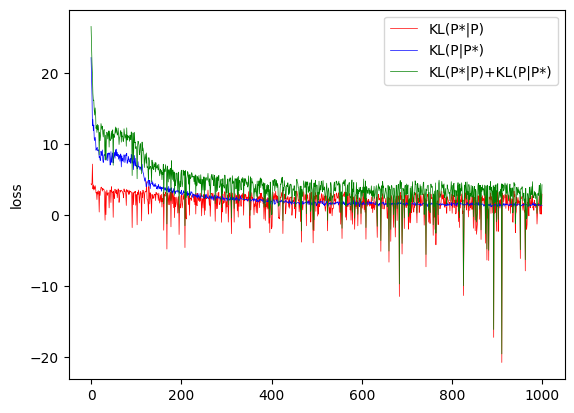

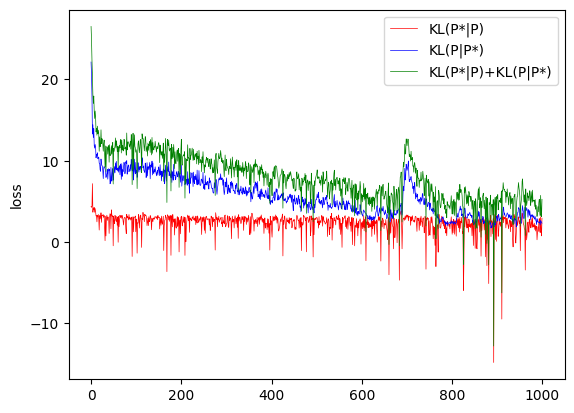

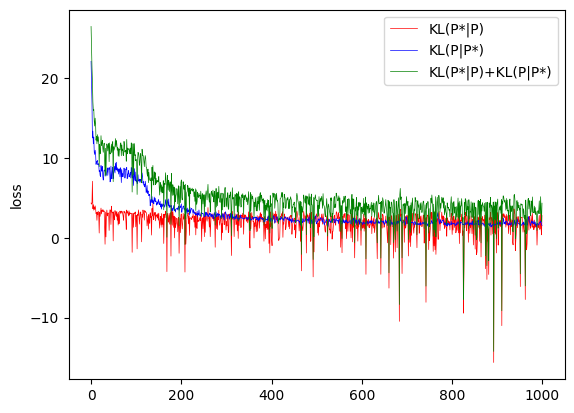

/tmp/ipykernel_1050951/16795951.py:15: RuntimeWarning: invalid value encountered in log
  CE, = plt.plot(np.log(5+np.array(models[i].loss_log_CE)), color = 'red', linewidth = 0.5)
/tmp/ipykernel_1050951/16795951.py:17: RuntimeWarning: invalid value encountered in log
  RECE, = plt.plot(np.log(5+np.array(models[i].loss_log_CERE)),color = 'green', linewidth = 0.5)


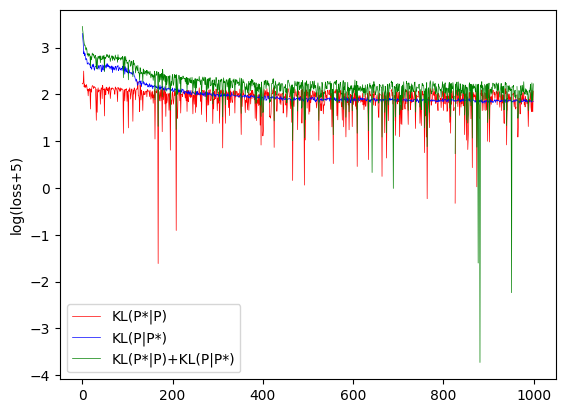

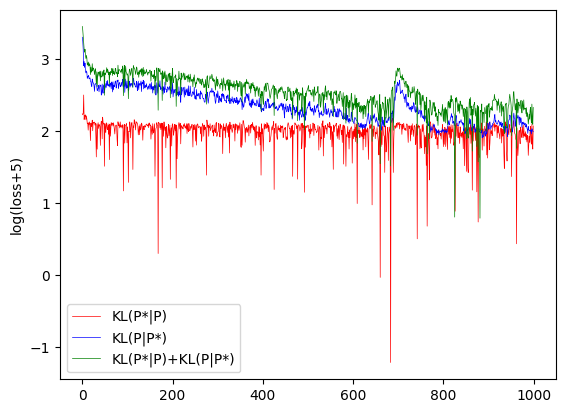

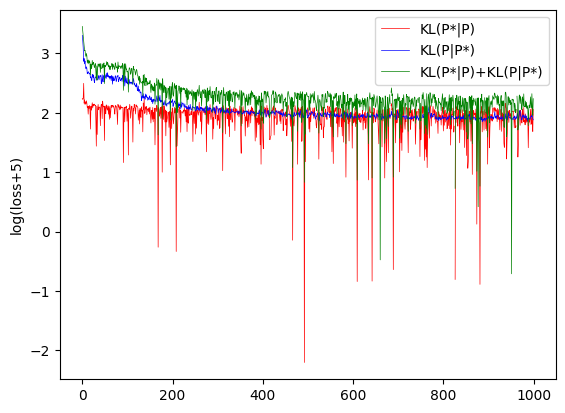

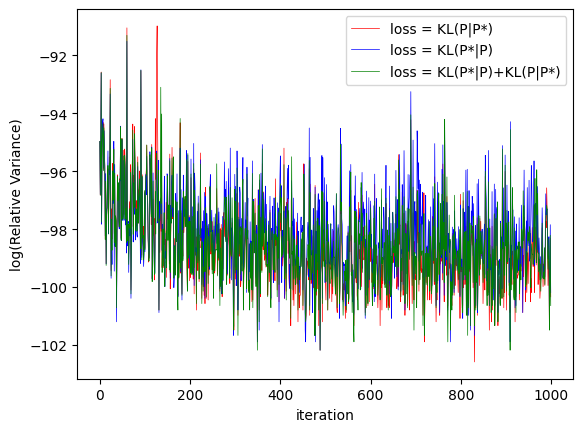

In [ ]:
#fig = plot_loss_logs('LQGC Adam', models) # lr = 0.1
for i in range(3):
    CE, = plt.plot(np.array(models[i].loss_log_CE), color = 'red', linewidth = 0.5)
    RE, = plt.plot(np.array(models[i].loss_log_REdirect) ,color = 'blue', linewidth = 0.5)
    RECE, = plt.plot(np.array(models[i].loss_log_CERE),color = 'green', linewidth = 0.5)

    plt.ylabel('loss')

    plt.legend(handles=[CE,RE,RECE],labels=['KL(P*|P)','KL(P|P*)','KL(P*|P)+KL(P|P*)'],loc='best')
    
    plt.show()


for i in range(3):
    CE, = plt.plot(np.log(5+np.array(models[i].loss_log_CE)), color = 'red', linewidth = 0.5)
    RE, = plt.plot(np.log(5+np.array(models[i].loss_log_REdirect)) ,color = 'blue', linewidth = 0.5)
    RECE, = plt.plot(np.log(5+np.array(models[i].loss_log_CERE)),color = 'green', linewidth = 0.5)

    plt.ylabel('log(loss+5)')

    plt.legend(handles=[CE,RE,RECE],labels=['KL(P*|P)','KL(P|P*)','KL(P*|P)+KL(P|P*)'],loc='best')
    
    plt.show()

var0, = plt.plot(np.log(np.array(models[0].relvar_log)),color = 'red', linewidth = 0.5)
var1, = plt.plot(np.log(np.array(models[1].relvar_log)),color = 'blue', linewidth = 0.5)
var2, = plt.plot(np.log(np.array(models[2].relvar_log)),color = 'green', linewidth = 0.5)



plt.ylabel('log(Relative Variance)')
plt.xlabel('iteration')



plt.legend(handles=[var0,var1,var2],labels=['loss = KL(P|P*)','loss = KL(P*|P)','loss = KL(P*|P)+KL(P|P*)'],loc='best')
plt.show()



# print(np.exp(models[0].Z_n_(models[0].X_0.repeat(1,1).to(models[0].device),0).item()))

# IAPF

In [9]:
'''
run IAPF in " The Iterated Auxiliary Particle Filter " or " Controlled Sequential Monte Carlo "
'''
from scipy.optimize import lsq_linear
import time

# np.seterr(all='ignore')
#print(mu_k[40], sigma2_k[40])

def gk(x,y):
    return np.exp(log_gk(x,y))

def log_gk(xx,yy):
    exponent = -0.5 * np.sum((xx**2/ 20 - yy ) ** 2, axis=1)
    return exponent

def b_np(x):
    return (x/2 + 25 * x / (1 + np.sum(x**2, axis=1,keepdims = True)) - x) / delta_t

def tildephik_1(x, delta_t, d, sigmak2, muk):
    return np.power(2 * np.pi * (delta_t + sigmak2), -d/2)\
          * np.exp(-np.linalg.norm(x + delta_t * b_np(x) - muk, axis=1)**2 / (2 * (delta_t + sigmak2)))

def log_tildephik_1(x, delta_t, d, sigmak2, muk):
    return (-d/2) * np.log(2 * np.pi * (delta_t + sigmak2))\
          + (-np.linalg.norm(x + delta_t * b_np(x) - muk, axis=1)**2 / (2 * (delta_t + sigmak2)))

def phik(x, d, sigmak2, muk):#gaussian
    return np.power(2 * np.pi * (sigmak2), -d/2)\
          * np.exp(-np.linalg.norm(x  - muk, axis=1)**2 / (2 * (sigmak2)))


def tildephik_1_scale(x, delta_t, d, sigmak2, muk):
    return np.power(((delta_t / sigmak2) + 1), -d/2)\
          * np.exp(-np.linalg.norm(x + delta_t * b_np(x) - muk, axis=1)**2 / (2 * (delta_t + sigmak2)))

def phik_scale(x, d, sigmak2, muk):#gaussian
    return np.exp(-np.linalg.norm(x  - muk, axis=1)**2 / (2 * (sigmak2)))

def L2objective(params, xi, psi):
    dd = xi.shape[1]
    mean = params[:dd]
    variance = params[dd]
    lambda_ = params[dd + 1]
    NN = len(xi)
    
    total_sum = 0
    N_xi = np.power(2 * np.pi * variance, -dd/2) * np.exp(-np.linalg.norm(xi - mean, axis=1)**2 / (2 * variance))
    total_sum = np.sum((N_xi - lambda_ * psi)**2)
    
    # for i in range(NN):
    #     N_xi = np.power(2 * np.pi * (variance), -dd/2)\
    #       * np.exp(-np.linalg.norm(xi[i]  - mean)**2 / (2 * (variance)))
    #     total_sum += (N_xi - lambda_ * psi[i])**2
    return total_sum

def L2objective_variant(params, xi, psi):
    dd = xi.shape[1]
    mean = params[:dd]
    var_inverse = params[dd]
    lambda_ = params[dd + 1]
    NN = len(xi)
    
    total_sum = 0
    N_xi = np.power(var_inverse / (2 * np.pi), +dd/2) * np.exp(-(np.linalg.norm(xi - mean, axis=1)**2) * 0.5 * var_inverse)
    total_sum = np.sum((N_xi - lambda_ * psi)**2)
    
    # for i in range(NN):
    #     N_xi = np.power(2 * np.pi * (variance), -dd/2)\
    #       * np.exp(-np.linalg.norm(xi[i]  - mean)**2 / (2 * (variance)))
    #     total_sum += (N_xi - lambda_ * psi[i])**2
    return total_sum

def L2objective_log(params, xi, psi):
    dd = xi.shape[1]
    mean = params[:dd]
    var_inverse = params[dd]
    lambda_ = params[dd + 1]
    NN = len(xi)
    
    total_sum = 0
    N_xi = - (np.linalg.norm(xi - mean, axis=1)**2) * 0.5 * var_inverse
    total_sum = np.sum((N_xi -  psi + lambda_)**2)
    return total_sum

def L2objective_log_grad(params, xi, psi):
    dd = xi.shape[1]
    mean = params[:dd]
    var_inverse = params[dd]
    lambda_ = params[dd + 1]
    NN = len(xi)

    N_xi = - (np.linalg.norm(xi - mean, axis=1)**2) * 0.5 * var_inverse

    grad_mean = - np.sum(2 * (N_xi - psi + lambda_)[:, None] * (-xi + mean) * var_inverse, axis=0)
    grad_var_inverse = np.sum((N_xi - psi + lambda_) * (-0.5 * np.linalg.norm(xi - mean, axis=1)**2))
    grad_lambda = np.sum(2 * (N_xi - psi + lambda_))

    grad = np.concatenate([grad_mean, [grad_var_inverse], [grad_lambda]])
    return grad

def backtracking_line_search(params, xi, psi, grad, alpha=0.3, beta=0.8):
    t = 1
    while L2objective_log(params - t * grad, xi, psi) > L2objective_log(params, xi, psi) - alpha * t * np.dot(grad, grad):
        t *= beta
    return t

def gradient_descent(params, xi, psi, learning_rate=1e-3, max_iter=10000, tol=1e-6):
    for i in range(max_iter):
        grad = L2objective_log_grad(params, xi, psi)
        step_size = backtracking_line_search(params, xi, psi, grad)
        new_params = params - step_size * grad
        
        if np.linalg.norm(new_params - params) < tol:
            print(f"Converged after {i+1} iterations.")
            break
        
        params = new_params
        
    return params

def my_lsqsolver(xi, psi):
    NN, dd = xi.shape

    A = np.hstack([np.sum(np.square(xi), axis=1).reshape(-1, 1), xi, np.ones((NN, 1))])

    bounds = ([-np.inf] + [-np.inf]*d + [-np.inf], [0] + [np.inf]*d + [np.inf])  # a <= 0, b and c are unbounded

    result = lsq_linear(A, psi, bounds=bounds)

    lsa = result.x[0]
    lsb = result.x[1:d+1]
    lsc = result.x[d+1]

    sigma2 = - 1.0 / (2 * lsa)
    mu = - lsb / (2 * lsa)
    lambda_ = lsc + np.square(lsb) / (8 * lsa * lsa)

    return sigma2, mu, lambda_


# def my_lsqsolver(xi, psi):
#     NN, dd = xi.shape

#     def objective(params):
#         # Extract L, b, and c from params
#         L = np.tril(np.zeros((dd, dd)))
#         L[np.tril_indices(dd)] = params[:dd*(dd+1)//2]
#         b = params[dd*(dd+1)//2:dd*(dd+1)//2 + dd]
#         c = params[dd*(dd+1)//2 + dd]

#         A = L @ L.T
#         residuals = psi - np.sum(xi @ A * xi, axis=1) - xi @ b - c
#         return np.sum(residuals**2)

#     # Initial guess for L (lower triangular part), b, and c
#     L_init = np.eye(dd)[np.tril_indices(dd)]
#     b_init = np.zeros(dd)
#     c_init = 0
#     initial_params = np.hstack([L_init, b_init, c_init])

#     # Minimize the objective function
#     result = minimize(objective, initial_params, method='L-BFGS-B')

#     # Extract optimal L, b, and c from result
#     L_opt = np.tril(np.zeros((dd, dd)))
#     L_opt[np.tril_indices(dd)] = result.x[:dd*(dd+1)//2]
#     b_opt = result.x[dd*(dd+1)//2:dd*(dd+1)//2 + dd]
#     c_opt = result.x[dd*(dd+1)//2 + dd]

#     A_opt = L_opt @ L_opt.T
#     covinv = -2 * A_opt
#     mu = -np.linalg.solve(2*A_opt, b_opt)
#     #lambda_ = c_opt + np.dot(b_opt, np.linalg.solve(A_opt, b_opt)) / 8

#     return covinv, mu




N = int(T / delta_t)
IAPF_iter_num = 3
K_IAPF = K_BPF_small
K_IAPF = 200
Z_IAPF = []
IAPF_muk, IAPF_sigma2k = [np.zeros([d]) for i in range(N+1)], np.ones(N+1)


y_observed_KBPFL = []#define y_OB for K_BPF_large particles
for n in range(N + 1):
    y_observed_KBPFL.append(y_observed[n].repeat(K_IAPF,1).to('cpu').numpy())

for i_IAPF in range(IAPF_iter_num):
    print('iteration', i_IAPF, end = ' ')
    if(i_IAPF == 0):
        '''
        run a BPF
        ''' 
        X_IAPF_np = [np.ones([d,K_IAPF]) for i in range(N+2)]
        X_IAPF_np[0] = pt.ones(d).repeat(K_IAPF,1).numpy()#initial
        
        
        g_prod = 1
        for n in range(N+1):
            g_k = gk(X_IAPF_np[n] , y_observed_KBPFL[n])
            g_prod *= g_k.mean()                   
                    
            #resample
            weights = g_k / g_k.sum()
            indices = np.random.choice(K_IAPF, K_IAPF, p=weights)
            
            X_IAPF_np_rs = X_IAPF_np[n][indices]

            #update particle position
            X_IAPF_np[n+1] = X_IAPF_np_rs + delta_t * b_np(X_IAPF_np_rs) + np.sqrt(delta_t) * np.random.randn(*X_IAPF_np_rs.shape)
            
        Z_IAPF.append(g_prod)
        print(np.log(g_prod))
        
    else:
        time0 = time.time()
        '''
        iteratively learn meank, variancek of the twisting function
        '''
        k_IAPF = N
        while(k_IAPF>=1):
            if(k_IAPF == N):
                IAPF_muk[N] = y_observed[N].to('cpu').numpy()
                IAPF_sigma2k[N] = OBsigma2
                k_IAPF -= 1
            
            else:
                #backward recursive
                varphik = gk(X_IAPF_np[k_IAPF] , y_observed_KBPFL[k_IAPF]) * tildephik_1(X_IAPF_np[k_IAPF], delta_t, d, IAPF_sigma2k[k_IAPF+1], IAPF_muk[k_IAPF+1])
                log_varphi_k = log_gk(X_IAPF_np[k_IAPF] , y_observed_KBPFL[k_IAPF]) + log_tildephik_1(X_IAPF_np[k_IAPF], delta_t, d, IAPF_sigma2k[k_IAPF+1], IAPF_muk[k_IAPF+1])
                #varphik = gk(X_IAPF_np[k_IAPF] - y_observed_KBPFL[k_IAPF]) * tildephik_1_scale(X_IAPF_np[k_IAPF], delta_t, d, IAPF_sigma2k[k_IAPF+1], IAPF_muk[k_IAPF+1])
                #print(log_varphi_k)
                #L2 minimization
            
                IAPF_sigma2k[k_IAPF], IAPF_muk[k_IAPF], lambda_ = my_lsqsolver(X_IAPF_np[k_IAPF], log_varphi_k)

                if(k_IAPF == 40):
                    print(IAPF_muk[k_IAPF], IAPF_sigma2k[k_IAPF])
                    

                k_IAPF -= 1

        # for n in range(1,N+1):
        #     IAPF_muk[n], IAPF_sigma2k[n] = mu_k[n], sigma2_k[n]
        '''
        run a TPF using the updated muk, sigma2k
        ''' 
        X_IAPF_np = [np.zeros([d,K_IAPF]) for i in range(N+2)]
        X_IAPF_np[0] = pt.ones(d).repeat(K_IAPF,1).numpy()#initial
                
        g_prod = 1
        for n in range(N+1):
            g_k = gk(X_IAPF_np[n] , y_observed_KBPFL[n])

            #calculate gphik       
            if(n == N):
                #gphi_k = g_k / phik_scale(X_IAPF_np[n], d, IAPF_sigma2k[n], IAPF_muk[n])
                gphi_k = g_k / phik(X_IAPF_np[n], d, IAPF_sigma2k[n], IAPF_muk[n])
                
            elif(n == 0):
                #gphi_k = g_k * tildephik_1_scale(X_IAPF_np[n], delta_t, d, IAPF_sigma2k[n+1], IAPF_muk[n+1])
                gphi_k = g_k * tildephik_1(X_IAPF_np[n], delta_t, d, IAPF_sigma2k[n+1], IAPF_muk[n+1])
                              
            else:
                # gphi_k = g_k * tildephik_1_scale(X_IAPF_np[n], delta_t, d, IAPF_sigma2k[n+1], IAPF_muk[n+1])\
                #       / phik_scale(X_IAPF_np[n], d, IAPF_sigma2k[n], IAPF_muk[n])
                gphi_k = g_k * tildephik_1(X_IAPF_np[n], delta_t, d, IAPF_sigma2k[n+1], IAPF_muk[n+1])\
                      / phik(X_IAPF_np[n], d, IAPF_sigma2k[n], IAPF_muk[n])

            g_prod *= gphi_k.mean()
            

            #resample
            weights = gphi_k / gphi_k.sum()
            indices = np.random.choice(K_IAPF, K_IAPF, p=weights, replace = True)
            
            X_IAPF_np_rs = X_IAPF_np[n][indices]
            #X_IAPF_np_rs = X_IAPF_np[n]
            
            
            
            #X_IAPF_np_rs = X_IAPF_np[n][indices]
            
            #update X
            if(n<=N-1):
                X_IAPF_np[n+1] = (delta_t * IAPF_muk[n+1] + IAPF_sigma2k[n+1] * (X_IAPF_np_rs+ delta_t * b_np(X_IAPF_np_rs)) / (delta_t + IAPF_sigma2k[n+1]))\
                  + np.sqrt((delta_t * IAPF_sigma2k[n+1]) / (delta_t + IAPF_sigma2k[n+1])) * np.random.randn(*X_IAPF_np_rs.shape)
        
        Z_IAPF.append(g_prod)
        time1 = time.time()
        print('time:',time1-time0,'logZ:', np.log(g_prod))
        if(abs(np.log(Z_IAPF[i_IAPF]) -np.log(Z_IAPF[i_IAPF-1])) <= 0.00001):
            break




iteration 0 -52.276675570282734
iteration 1 time: 0.018784284591674805 logZ: -52.75850870852948
iteration 2 time: 0.018919944763183594 logZ: -52.64656845233843


In [10]:
'''
run a TPF using the updated muk, sigma2k
''' 
K_IAPF = 200
print('use', K_IAPF, 'particles')


IAPF_Z_forcompare, IAPF_logZ_forcompare = [], []
y_observed_KBPFL = []#define y_OB for K_BPF_large particles
for n in range(N + 1):
    y_observed_KBPFL.append(y_observed[n].repeat(K_IAPF,1).to('cpu').numpy())
    

average_ESSnum_IAPF = 0
ESS_ave = 0
for ii in range(replicate_num):
    ithESSnum = 0

    XX_IAPF_np = [np.ones([d,K_IAPF]) for i in range(N+2)]
    XX_IAPF_np[0] = pt.ones(d).repeat(K_IAPF,1).numpy()#initial
            
    g_prod = 1
    for n in range(N+1):
        g_k = gk(XX_IAPF_np[n] , y_observed_KBPFL[n])

        #calculate gphik       
        if(n == N):
            #gphi_k = g_k / phik_scale(X_IAPF_np[n], d, IAPF_sigma2k[n], IAPF_muk[n])
            gphi_k = g_k / phik(XX_IAPF_np[n], d, IAPF_sigma2k[n], IAPF_muk[n])
            
        elif(n == 0):
            #gphi_k = g_k * tildephik_1_scale(X_IAPF_np[n], delta_t, d, IAPF_sigma2k[n+1], IAPF_muk[n+1])
            gphi_k = g_k * tildephik_1(XX_IAPF_np[n], delta_t, d, IAPF_sigma2k[n+1], IAPF_muk[n+1])
                            
        else:
            # gphi_k = g_k * tildephik_1_scale(X_IAPF_np[n], delta_t, d, IAPF_sigma2k[n+1], IAPF_muk[n+1])\
            #       / phik_scale(X_IAPF_np[n], d, IAPF_sigma2k[n], IAPF_muk[n])
            gphi_k = g_k * tildephik_1(XX_IAPF_np[n], delta_t, d, IAPF_sigma2k[n+1], IAPF_muk[n+1])\
                    / phik(XX_IAPF_np[n], d, IAPF_sigma2k[n], IAPF_muk[n])

        g_prod *= gphi_k.mean()

        #resample
        weights = gphi_k / gphi_k.sum()
        indices = np.random.choice(K_IAPF, K_IAPF, p=weights, replace = True)
        ESS = 1.0 / np.sum(weights**2)
        ESS_ave += ESS
        

        if(ESS <= resample_kappa * K_IAPF):
            XX_IAPF_np_rs = XX_IAPF_np[n][indices]
            ithESSnum += 1
        else:
            XX_IAPF_np_rs = XX_IAPF_np[n]
        
        
        #X_IAPF_np_rs = X_IAPF_np[n][indices]
        
        #update X
        if(n<=N-1):
            XX_IAPF_np[n+1] = (delta_t * IAPF_muk[n+1] + IAPF_sigma2k[n+1] * (XX_IAPF_np_rs+ delta_t * b_np(XX_IAPF_np_rs)) / (delta_t + IAPF_sigma2k[n+1]))\
                + np.sqrt((delta_t * IAPF_sigma2k[n+1]) / (delta_t + IAPF_sigma2k[n+1])) * np.random.randn(*XX_IAPF_np_rs.shape)

    print(ii, 'logZ = ', np.log(g_prod))
    IAPF_Z_forcompare.append(g_prod)
    IAPF_logZ_forcompare.append(np.log(g_prod))

    average_ESSnum_IAPF += ithESSnum

average_ESSnum_IAPF /= replicate_num

if(resample_kappa < 1):
    print('average ESS number:', average_ESSnum_IAPF)

ESS_ave /= (replicate_num * (N+1))
print('ESS_ave=', ESS_ave, 'ESS_ave percentage=', ESS_ave / K_IAPF)


use 200 particles
0 logZ =  -52.69735925874426
1 logZ =  -52.69190248310312
2 logZ =  -52.27564149641413
3 logZ =  -52.30630427421262
4 logZ =  -52.504633172475586
5 logZ =  -52.17549280907261
6 logZ =  -52.496539008027284
7 logZ =  -52.065286442265545
8 logZ =  -52.22058095707242
9 logZ =  -52.668666144267696
10 logZ =  -52.67515654093757
11 logZ =  -52.898038320159664
12 logZ =  -52.99359139425606
13 logZ =  -52.31315903159352
14 logZ =  -52.3836871454434
15 logZ =  -52.71173730843083
16 logZ =  -52.371109867341296
17 logZ =  -52.356677648522854
18 logZ =  -52.57303786829167
19 logZ =  -52.7423364771847
ESS_ave= 194.4906158650652 ESS_ave percentage= 0.972453079325326


# boxplot

In [12]:
import matplotlib
matplotlib.use('Agg')

logfig, logax = plt.subplots()
print(logZ_BPF)
print(models[0].TPF_logZ)
#print(log_Z_KF)
print('SD_TPF(CE):',math.sqrt(np.var(models[1].TPF_logZ)))

print('SD_BPF:',math.sqrt(np.var(logZ_BPF)))
print('SD_TPF(RE):',math.sqrt(np.var(models[0].TPF_logZ )))
print('SD_TPF(CE):',math.sqrt(np.var(models[1].TPF_logZ)))
print('SD_TPF(RECE):',math.sqrt(np.var(models[2].TPF_logZ)))
print('SD_IAPF:', math.sqrt(np.var(IAPF_logZ_forcompare)))
print('SD_FA-APF:', math.sqrt(np.var(FAAPF_logZ_forcompare )))




meanprops={'marker':'x', 'markerfacecolor':'red', 'markeredgecolor':'red'}
medianprops = {'color': 'red', 'linestyle': '--', 'linewidth': 1}
logbp1 = logax.boxplot(logZ_BPF ,  widths=0.1,
                  showfliers=False, positions = np.array(range(1))*2.0+1, showmeans=True,meanprops = meanprops,medianprops=medianprops)
logbp2 = logax.boxplot(models[0].TPF_logZ ,  widths=0.1,
                  showfliers=False,positions = np.array(range(1))*2.0+2, showmeans=True,meanprops = meanprops,medianprops=medianprops)
logbp3 = logax.boxplot(models[1].TPF_logZ ,  widths=0.1,
                  showfliers=False,positions = np.array(range(1))*2.0+3, showmeans=True,meanprops = meanprops,medianprops=medianprops)
logbp4 = logax.boxplot(models[2].TPF_logZ ,  widths=0.1,
                  showfliers=False,positions = np.array(range(1))*2.0+4, showmeans=True,meanprops = meanprops,medianprops=medianprops)
logbp5 = logax.boxplot(IAPF_logZ_forcompare ,  widths=0.1,
                  showfliers=False,positions = np.array(range(1))*2.0+5, showmeans=True,meanprops = meanprops,medianprops=medianprops)
logbp6 = logax.boxplot(FAAPF_logZ_forcompare ,  widths=0.1,
                  showfliers=False,positions = np.array(range(1))*2.0+6, showmeans=True,meanprops = meanprops,medianprops=medianprops)

# logbp5 = logax.boxplot(models[0].TPF_logZ - np.log(Z_true),  widths=0.1,
#                   showfliers=False,positions = np.array(range(1))*2.0+5, showmeans=True,meanprops = meanprops,medianprops=medianprops)


# all_data = np.concatenate([
#     logZ_BPF ,
#     models[0].TPF_logZ ,
#     models[1].TPF_logZ ,
#     models[2].TPF_logZ ,
#     IAPF_logZ_forcompare ,
#     FAAPF_logZ_forcompare 
# ])
# y_max = np.max(np.abs(all_data))

# Set the y-axis limits to be symmetric around 0
#logax.set_ylim(-y_max, y_max)

#plt.axhline(0, color='gray', linestyle='--')


logax.set_xticks([1,2,3,4,  5,6])
logax.set_xticklabels(['BPF', 'TPF(RE)', 'TPF(CE)',  'TPF(RECE)', 'iAPF', 'FA-APF'])
#logax.set_xticklabels(['BPF',  'iAPF', 'FA-APF'])
#logax.set_xticklabels(['BPF',  'iAPF', 'FA-APF'])

logax.set_ylabel('logZ - logZtrue')


plt.title('LogZ Estimates, d = 5')

plt.legend(frameon=False)

plt.savefig('NGM5d.eps', format = 'eps')

plt.show()







# fig, ax = plt.subplots()



# meanprops={'marker':'x', 'markerfacecolor':'red', 'markeredgecolor':'red'}
# medianprops = {'color': 'red', 'linestyle': '--', 'linewidth': 1}
# bp1 = ax.boxplot((logZ_BPF - np.log(Z_true)) / np.log(Z_true),  widths=0.1,
#                   showfliers=False, positions = np.array(range(1))*2.0+1, showmeans=True,meanprops = meanprops,medianprops=medianprops)
# bp2 = ax.boxplot((models[0].TPF_logZ - np.log(Z_true)) / np.log(Z_true),  widths=0.1,
#                   showfliers=False,positions = np.array(range(1))*2.0+2, showmeans=True,meanprops = meanprops,medianprops=medianprops)
# bp3 = ax.boxplot((models[1].TPF_logZ - np.log(Z_true)) / np.log(Z_true),  widths=0.1,
#                   showfliers=False,positions = np.array(range(1))*2.0+3, showmeans=True,meanprops = meanprops,medianprops=medianprops)
# bp4 = ax.boxplot((models[2].TPF_logZ - np.log(Z_true)) / np.log(Z_true),  widths=0.1,
#                   showfliers=False,positions = np.array(range(1))*2.0+4, showmeans=True,meanprops = meanprops,medianprops=medianprops)

# # bp5 = ax.boxplot((models[0].TPF_logZ - np.log(Z_true)) / np.log(Z_true),  widths=0.1,
# #                   showfliers=False,positions = np.array(range(1))*2.0+5, showmeans=True,meanprops = meanprops,medianprops=medianprops)

# ax.set_xticks([1, 2, 3, 4])
# ax.set_xticklabels(['BPF', 'TPF(RE)', 'TPF(CE)', 'TPF(RECE)'])

# # 设置y轴标签
# ax.set_ylabel('(logZ - logZtrue) / logZtrue')

# # 添加标题并显示图形
# plt.title('LogZ Estimates, d = 15, 1000 replicates')
# plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-52.48165144816284, -52.76472578014487, -52.39963456353084, -52.35966448090446, -52.441217358382296, -52.62023339588437, -52.64769018357723, -52.6941794472264, -52.49494684872138, -52.239048456486636, -52.46416072896865, -52.47117135425321, -52.40851865627832, -52.21430004093187, -52.35511026635127, -52.413699046597806, -52.12735021461471, -52.417009744302796, -52.59750568560136, -52.35564230617957]
[-52.55535594272171, -52.42671134998439, -52.460336967806654, -52.306738295785266, -52.357831486033795, -52.657163217947804, -52.507818304691604, -52.32692106911335, -52.540286276557694, -52.40623920341536, -52.50649128901137, -52.4693950427886, -52.42287182922249, -52.508692680700904, -52.572783356686436, -52.62119509332938, -52.47863441647784, -52.37590398862935, -52.33992039285625, -52.649016404921404]
SD_TPF(CE): 0.17777019771156127
SD_BPF: 0.1563775859750016
SD_TPF(RE): 0.10256449706751616
SD_TPF(CE): 0.17777019771156127
SD_TPF(RECE): 0.11439031864013115
SD_IAPF: 0.2440257552513239
SD